# グローバーのアルゴリズムを使って、データベース検索を行う

ここでは、**グローバーのアルゴリズム**の紹介と、そのアルゴリズムを使用して構造化されていないデータベースを検索する問題を考えます。アルゴリズムを説明した後に、Qiskitを使用してグローバーのアルゴリズムを実装します。

```{contents} 目次
---
local: true
---
```

## はじめに <a id='introduction'></a>

量子コンピュータが古典コンピュータの計算能力を優位に上回る性能を発揮するためには、量子計算の特徴をうまく活用するアルゴリズムを考える必要があります。そのような量子アルゴリズムの一つとして知られているのが、グローバーのアルゴリズムです。このアルゴリズムは**構造化されていないデータベースの検索**に適しており、古典計算より少ない計算量で答えを得られることが証明されています。このアルゴリズムは**振幅増幅**と呼ばれる手法をベースにしており、量子アルゴリズムのサブルーチンとしても幅広く活用されています。

## 非構造化データの検索 <a id='database'></a>

$N$個の要素からなるリストがあり、その中の一つの要素$w$を見つけたいとします。求める要素$w$を見つけるためには、古典計算では最悪の場合$N$回、平均では$\boldsymbol{N/2}$回リストを調べる必要があります。グローバーのアルゴリズムでは、おおよそ$\boldsymbol{\sqrt{N}}$回の検索で$w$を見つけることができることが知られています。つまり、**古典計算に対して二次の高速化が可能**というわけです。

## グローバーのアルゴリズム <a id='grover'></a>

ここでは$n$個の量子ビットを考え、その量子ビットが存在する可能性のある全ての計算基底でリストが構成されているものとします。つまり$N=2^n$として、リストは$|00\cdots00\rangle$, $|00\cdots01\rangle$, $|00\cdots10\rangle$, $\cdots$, $|11\cdots11\rangle$までの$N$個の要素（10進数表記で$|0\rangle$, $|1\rangle$, $\cdots$, $|N-1\rangle$）を含んでいます。

### 位相オラクルの導入 <a id='grover_phaseoracle'></a>

グローバーのアルゴリズムで重要になるのは、特定の状態の位相を変える位相オラクルです。まず、$U|x\rangle=(-1)^{f(x)}|x\rangle$で与えられる位相オラクルを考えます。ここで関数$f(x)$として

$$
f(x) = \bigg\{
\begin{aligned}
&1 \quad \text{if} \; x = w \\
&0 \quad \text{else} \\
\end{aligned}
$$

を考えると、求める解$w$の位相を反転するオラクル$U_w$

$$
U_w:\begin{aligned}
&|w\rangle \to -|w\rangle\\
&|x\rangle \to |x\rangle \quad \forall \; x \neq w
\end{aligned}
$$

が得られます。この時、$U_w$は$U_w=I-2|w\rangle\langle w|$と表現できることが分かります。また、関数$f_0(x)$として

$$
f_0(x) = \bigg\{
\begin{aligned}
&0 \quad \text{if} \; x = 0 \\
&1 \quad \text{else} \\
\end{aligned}
$$

を考えると、0以外の位相を反転するユニタリー$U_0$

$$
U_0:\begin{aligned}
&|0\rangle^{\otimes n} \to |0\rangle^{\otimes n}\\
&|x\rangle \to -|x\rangle \quad \forall \; x \neq 0
\end{aligned}
$$

を得ることができます。この時、$U_0$は$U_0=2|0\rangle\langle 0|^{\otimes n}-I$になります。

### 量子回路の構成 <a id='grover_circuit'></a>

グローバーアルゴリズムを実装する量子回路の構造は、下図のようになっています。$|0\rangle$に初期化された状態から出発し、Hadamard演算を適用して重ね合わせ状態を作ります。その後、
$G$と書かれている演算を繰り返し適用します。

```{image} figs/grover.png
:height: 300px
```

$G$は「グローバーの反復」とも呼ばれるユニタリー演算で、以下のような4つのステップから構成されています。

```{image} figs/grover_iter.png
:height: 300px
```

回路の最初にあるHadamard演算と合わせて、グローバーの反復を1回実行するまでのステップ

```{image} figs/grover_iter1.png
:height: 300px
```

を細かく見ていきましょう。

### 重ね合わせ状態の生成 <a id='grover_superposition'></a>
まず、$n$量子ビット回路の初期状態$|0\rangle^{\otimes n}$にHadamard演算を適用し、一様に重ね合わされた状態を生成します。

$$
|s\rangle = H^{\otimes n}|0\rangle^{\otimes n} = \frac{1}{\sqrt{N}}\sum_{x=0}^{N-1}|x\rangle
$$

この状態を$|s\rangle$とします。

### 幾何学的な表現 <a id='grover_geometry'></a>
この$|s\rangle$の状態を幾何学的に表現してみましょう。まず、重ね合わせ状態$|s\rangle$と求める状態$|w\rangle$が張る2次元平面を考えます。$|w\rangle$に直交する状態$|w^{\perp}\rangle$は$|w^{\perp}\rangle:=\frac{1}{\sqrt{N-1}}\sum_{x \neq w}|x\rangle$と表現できるため、この平面上では$|w\rangle$に直交する軸に相当します。簡易的に、この平面では$|w^{\perp}\rangle=\begin{bmatrix}1\\0\end{bmatrix}$と$|w\rangle=\begin{bmatrix}0\\1\end{bmatrix}$と書くことにします。

まとめると、この2次元平面では、$|s\rangle$は($|w^{\perp}\rangle$, $|w\rangle$)という二つのベクトルの線形和として書くことができます。

$$
\begin{aligned}
|s\rangle&=\sqrt{\frac{N-1}{N}}|w^{\perp}\rangle+\sqrt{\frac1N}|w\rangle\\
&=: \cos\frac\theta2|w^{\perp}\rangle+\sin\frac\theta2|w\rangle\\
&= \begin{bmatrix}\cos\frac\theta2\\\sin\frac\theta2\end{bmatrix}
\end{aligned}
$$

答えが一つであるため、$|w\rangle$の振幅は$\sqrt{\frac1N}$、$|w^{\perp}\rangle$の振幅は$\sqrt{\frac{N-1}{N}}$になります。$\sin\frac\theta2=\sqrt{\frac1N}$なる$\theta$を定義すると、

$$
\theta=2\arcsin\frac{1}{\sqrt{N}}
$$

になります。($|w^{\perp}\rangle$, $|w\rangle$)平面での$|s\rangle$を図示すると、以下のようになります。

```{image} figs/grover_rot1.png
:height: 300px
```

### オラクルの適用 <a id='grover_oracle'></a>
次に、$|s\rangle$にオラクル$U_w$を適用します。このオラクルは、この平面上では$U_w=I-2|w\rangle\langle w|=\begin{bmatrix}1&0\\0&-1\end{bmatrix}$と表現することが可能です。つまり、$U_w$は$|w^{\perp}\rangle$軸に関して$|s\rangle$を折り返す操作（下図）に対応しており、この操作で$|w\rangle$の位相が反転します。

```{image} figs/grover_rot2.png
:height: 300px
```

### Diffuserの適用 <a id='grover_diffuser'></a>
次は$H^{\otimes n}U_0H^{\otimes n}$の適用で、この演算はDiffuserと呼ばれます。$U_0=2|0\rangle\langle0|^{\otimes n}-I$なので、

$$
\begin{aligned}
H^{\otimes n}U_0H^{\otimes n}&=2H^{\otimes n}|0\rangle^{\otimes n}\langle0|^{\otimes n}H^{\otimes n}-H^{\otimes n}H^{\otimes n}\\
&=2|s\rangle\langle s|-I\\
&=\begin{bmatrix}\cos\theta&\sin\theta\\\sin\theta&-\cos\theta\end{bmatrix}
\end{aligned}
$$

になります。つまり、Diffuserは$U_w|s\rangle$を$|s\rangle$に関して折り返す操作に対応します（下図）。

```{image} figs/grover_rot3.png
:height: 300px
```

まとめると、グローバーの反復$G=(2|s\rangle\langle s|-I)U_w$は

$$
\begin{aligned}
G&=(2|s\rangle\langle s|-I)U_w\\
&= \begin{bmatrix}\cos\theta&-\sin\theta\\\sin\theta&\cos\theta\end{bmatrix}
\end{aligned}
$$

であるため、$|s\rangle$を$|w\rangle$に向けて角度$\theta$だけ回転する操作を表していることが分かります（下図）。

```{image} figs/grover_rot4.png
:height: 300px
```

$G$を1回適用すれば$\theta$だけ回転するということは、$G$を$r$回繰り返せば$r\theta$回転することになります。その時の$|s\rangle$の状態は

$$
G^r|s\rangle=\begin{bmatrix}\cos\frac{2r+1}{2}\theta\\\sin\frac{2r+1}{2}\theta\end{bmatrix}
$$

で与えられます。つまり、求める答え$|w\rangle$に到達するためには、$\frac{2r+1}2\theta\approx\frac{\pi}2$となる$r$の回数だけ回転すれば良いことになります。
1回の回転角$\theta$が十分小さいとして、$\sin\frac\theta2=\frac{1}{\sqrt{N}}\approx\frac\theta2$とすると、$r\approx\frac\pi4\sqrt{N}$が得られます。つまり${\cal O}(\sqrt{N})$の操作で答え$|w\rangle$に到達することが示せたわけであり、古典計算に対する2次の高速化が得られることが分かりました。

Diffuserの役割をもう少し見てみましょう。ある状態$|\psi\rangle$が、$|\psi\rangle:=\sum_k a_k|k\rangle$という振幅$a_k$を持つ$|k\rangle$の重ね合わせ状態として書かれるとしましょう。この状態にDiffuserを適用すると

$$
\begin{aligned}
(2|s\rangle\langle s|-I)|\psi\rangle&=\frac2N\sum_i|i\rangle\cdot\sum_{j,k}a_k\langle j|k\rangle-\sum_k a_k|k\rangle\\
&= 2\frac{\sum_i a_i}{N}\sum_k|k\rangle-\sum_k a_k|k\rangle\\
&= \sum_k(2\langle a\rangle-a_k)|k\rangle
\end{aligned}
$$

となります。$\langle a\rangle\equiv\frac{\sum_i a_i}{N}$は振幅の平均です。ある状態$|k\rangle$の振幅$a_k$が$a_k=\langle a\rangle-\Delta$で与えられるとすると、Diffuserを適用した後の振幅は$2\langle a\rangle-a_k=\langle a\rangle+\Delta$になります。つまり、Diffuserは平均$\langle a\rangle$に関して振幅を反転する操作を表していることが分かります。

### 振幅増幅を可視化する <a id='grover_amp'></a>
グローバーアルゴリズムで振幅がどのように増幅されるのか、可視化するとこのようになります。

まず、最初のHadamard変換で全ての計算基底が等しい振幅を持つ重ね合わせ状態を生成します（下図の1）。横軸は$N$個の計算基底、縦軸は各基底の振幅の大きさを表しており、全ての基底が$\frac{1}{\sqrt{N}}$の大きさの振幅を持っています（振幅の平均を赤破線で表示）。

次にオラクル$U_w$を適用すると、$|w\rangle$の位相が反転し、振幅が$-\frac{1}{\sqrt{N}}$になります（下図の2）。この状態での振幅の平均は$\frac{1}{\sqrt{N}}(1-\frac2N)$になり、(1)の状態より低くなります。

最後にDiffuserを適用すると、平均に関して振幅を反転します（下図の3）。その結果、$|w\rangle$の振幅が増幅され、$|w\rangle$以外の基底の振幅は減少します。1回のグローバーの反復操作で、$|w\rangle$の振幅が約3倍程度増幅することも図から見てとれます。この操作を繰り返し実行すれば$|w\rangle$の振幅がさらに増幅されるため、正しい答えを得る確率が増加していくことも予想がつくと思います。

```{image} figs/grover_amp.png
:height: 300px
```

### 複数データの検索 <a id='grover_multidata'></a>
このセクションの最後に、複数のデータを検索する場合を考察してみましょう。例えば、$N=2^n$個のデータから$M$個のデータ$\{w_i\}\;(i=0,1,\cdots,M-1)$を探すケースです。これまでと同様に

$$
\begin{aligned}
&|w\rangle:=\frac{1}{\sqrt{M}}\sum_{i=0}^{M-1}|w_i\rangle\\
&|w^{\perp}\rangle:=\frac{1}{\sqrt{N-M}}\sum_{x\notin\{w_0,\cdots,w_{M-1}\}}|x\rangle
\end{aligned}
$$

が張る2次元平面の上で、同様の議論を進めることができます。$|s\rangle$はこの平面上で

$$
\begin{aligned}
|s\rangle&=\sqrt{\frac{N-M}{N}}|w^{\perp}\rangle+\sqrt{\frac{M}{N}}|w\rangle\\
&=: \cos\frac\theta2|w^{\perp}\rangle+\sin\frac\theta2|w\rangle\\
\end{aligned}
$$

と表現でき、$|w\rangle$の振幅$\sqrt{\frac{M}{N}}$を$\sin\frac\theta2$と定義すると、角度$\theta$は$\theta=2\arcsin\sqrt{\frac{M}{N}}$になります。答えが一つのケースと比べて、角度は$\sqrt{M}$倍大きく、1回のグローバーの反復操作でより大きく回転することになります。その結果、より少ない$r\approx\frac\pi4\sqrt{\frac{N}{M}}$回の回転操作で答えに到達することが可能になることが分かります。

## アルゴリズムの実装 ($N=2^6$の場合) <a id='imp'></a>
$N=2^6$個の要素を持つリスト（$=[0,1,2,\cdots,63]$）から、一つの答え"45"を見つけるグローバーアルゴリズムを実装してみます。6量子ビットの量子回路を使って、$|45\rangle=|101101\rangle$を探す問題です。

量子回路は以下のような構成になります。オラクルは$|101101\rangle$の状態の位相を反転するため、multi-controlled $Z$ゲートを使います。
Diffuserは（テンソル積 $\otimes 6$を省略して）$H(2|0\rangle\langle0|-I)H$に対応する部分です。$2|0\rangle\langle0|-I$で$|0\rangle$以外の基底の位相を反転しますが、この部分は最初に$R_Z(2\pi)$ゲートで全ての基底の位相を反転させ、その後に$|0\rangle$の場合だけ位相をさらに反転させることで実装します。

```{image} figs/grover_6bits_45.png
:height: 400px
```

### Qiskitでの実装 <a id='imp_qiskit'></a>

まず必要な環境をセットアップします。

In [1]:
# Tested with python 3.7.9, qiskit 0.23.5, numpy 1.20.1

import matplotlib.pyplot as plt
import numpy as np

# Qiskit関連のパッケージをインポート
from qiskit import IBMQ, Aer, QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.providers.ibmq import least_busy
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram

まず6量子ビットの回路を準備します。

In [2]:
n = 6
grover_circuit = QuantumCircuit(n)

一様な重ね合わせ状態$|s\rangle$を生成した後に、オラクルを実装します。

In [3]:
def initialize_s(qc, qubits):
    """回路のqubitsにHゲートを適用"""
    for q in qubits:
        qc.h(q)
    return qc

grover_circuit = initialize_s(grover_circuit, list(range(n)))

# オラクルを作成して、回路に実装
oracle= QuantumCircuit(n)

oracle.x(1)
oracle.x(4)
oracle.h(n-1)
oracle.mct(list(range(n-1)), n-1)
oracle.h(n-1)
oracle.x(1)
oracle.x(4)

oracle_gate = oracle.to_gate()
oracle_gate.name = "U_w"

grover_circuit.append(oracle_gate, list(range(n)))

次に、Diffuser用の回路を実装します。

In [4]:
def diffuser(n):
    qc = QuantumCircuit(n)

    qc.h(list(range(n)))
    qc.rz(2*np.pi, n-1)
    qc.x(list(range(n)))

    # multi-controlled Zゲート
    qc.h(n-1)
    qc.mct(list(range(n-1)), n-1)
    qc.h(n-1)

    qc.x(list(range(n)))
    qc.h(list(range(n)))

    U_s = qc.to_gate()
    U_s.name = "U_s"
    return U_s

grover_circuit.append(diffuser(n), list(range(n)))
grover_circuit.measure_all()
grover_circuit.draw()

┌───┐┌──────┐┌──────┐ ░ ┌─┐               
   q_0: ┤ H ├┤0     ├┤0     ├─░─┤M├───────────────
        ├───┤│      ││      │ ░ └╥┘┌─┐            
   q_1: ┤ H ├┤1     ├┤1     ├─░──╫─┤M├────────────
        ├───┤│      ││      │ ░  ║ └╥┘┌─┐         
   q_2: ┤ H ├┤2     ├┤2     ├─░──╫──╫─┤M├─────────
        ├───┤│  U_w ││  U_s │ ░  ║  ║ └╥┘┌─┐      
   q_3: ┤ H ├┤3     ├┤3     ├─░──╫──╫──╫─┤M├──────
        ├───┤│      ││      │ ░  ║  ║  ║ └╥┘┌─┐   
   q_4: ┤ H ├┤4     ├┤4     ├─░──╫──╫──╫──╫─┤M├───
        ├───┤│      ││      │ ░  ║  ║  ║  ║ └╥┘┌─┐
   q_5: ┤ H ├┤5     ├┤5     ├─░──╫──╫──╫──╫──╫─┤M├
        └───┘└──────┘└──────┘ ░  ║  ║  ║  ║  ║ └╥┘
meas: 6/═════════════════════════╩══╩══╩══╩══╩══╩═
                                 0  1  2  3  4  5

### シミュレータでの実験 <a id='imp_simulator'></a>

上の回路をシミュレータで実行して、結果をプロットしてみます。結果が分かりやすくなるように、測定したビット列を整数にしてからプロットするようにしてみます。

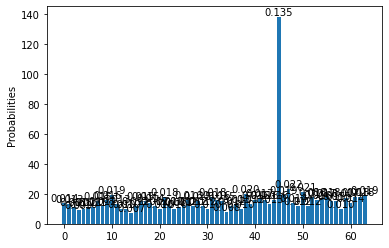

In [5]:
backend = Aer.get_backend('qasm_simulator')
results = execute(grover_circuit, backend=backend, shots=1024).result()
answer = results.get_counts()

# 横軸を整数でプロットする
def show_distribution(answer):
    n = len(answer)
    x = [int(key,2) for key in list(answer.keys())]
    y = list(answer.values())

    fig, ax = plt.subplots()
    rect = ax.bar(x,y)

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{:.3f}'.format(height/sum(y)),
                        xy=(rect.get_x()+rect.get_width()/2, height),xytext=(0,0),
                        textcoords="offset points",ha='center', va='bottom')
    autolabel(rect)
    plt.ylabel('Probabilities')
    plt.show()

show_distribution(answer)

この結果から、$|101101\rangle=|45\rangle$の状態が高い確率で測定できたことが分かります。

しかし、上での議論からも分かるように、$N=2^6$の探索では一回のグローバー反復では正しくない答えも無視できない確率で現れてきます。グローバーの反復を複数回繰り返すことで、正しい答えがより高い確率で得られることを課題として見ることにします。

### 量子コンピュータでの実験 <a id='imp_qc'></a>

以下ようにすることで、量子コンピュータで実行することができます。結果を確認してください。

In [6]:
# 量子コンピュータで実行する場合
from qiskit import IBMQ
IBMQ.enable_account('__paste_your_token_here__')

/usr/local/lib/python3.8/dist-packages/qiskit/providers/ibmq/ibmqfactory.py:109: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


RequestsApiError: '401 Client Error: Unauthorized for url: https://auth.quantum-computing.ibm.com/api/users/loginWithToken. Login failed., Error code: 3446.'

In [7]:
IBMQ.load_account()

/usr/local/lib/python3.8/dist-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


<AccountProvider for IBMQ(hub='ibm-q-utokyo', group='internal', project='icepp')>

In [19]:
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 6 and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_16_melbourne


In [22]:
# (Hidden cell) setting backend to None so that we don't submit a job every time 
backend = None

In [23]:
# 最も空いているバックエンドで回路を実行します。キュー内のジョブの実行をモニターします。
from qiskit.tools.monitor import job_monitor
job = execute(grover_circuit, backend=backend, shots=1024, optimization_level=3)
job_monitor(job, interval = 2)

Job Status: job has successfully run


In [24]:
# 計算結果
results = job.result()
answer = results.get_counts(grover_circuit)

In [29]:
# (Hidden cell) set to some dummy dict
answer = {'000000': 21, '000001': 15, '010000': 21, '010001': 10, '010010': 18, '010011': 14, '010100': 22, '010101': 13, '010110': 21, '010111': 11, '011000': 16, '011001': 9, '011010': 15, '011011': 12, '011100': 20, '011101': 13, '011110': 19, '011111': 11, '000010': 14, '100000': 26, '100001': 23, '100010': 20, '100011': 11, '100100': 16, '100101': 12, '100110': 13, '100111': 15, '101000': 19, '101001': 17, '101010': 13, '101011': 14, '101100': 17, '101101': 18, '101110': 23, '101111': 9, '000011': 21, '110000': 19, '110001': 17, '110010': 9, '110011': 16, '110100': 23, '110101': 21, '110110': 13, '110111': 8, '111000': 14, '111001': 20, '111010': 12, '111011': 9, '111100': 13, '111101': 17, '111110': 11, '111111': 8, '000100': 17, '000101': 18, '000110': 24, '000111': 19, '001000': 13, '001001': 15, '001010': 20, '001011': 16, '001100': 20, '001101': 13, '001110': 19, '001111': 18}

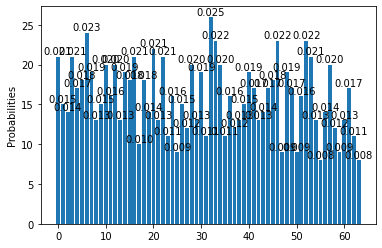

In [30]:
show_distribution(answer)

## [課題] 振幅増幅を確認する <a id='grover_application'></a>

グローバーのアルゴリズムを適用し、振幅が変化していく過程を可視化することを試みます。

上で考えた$N=2^6$個の要素リスト（$x\leq64$）から、適当な整数$x$を一つ選び、その数$x$を見つけるグローバーのアルゴリズムを実装してください。
- グローバーの反復を複数回繰り返すプログラムを作成してください。
- 探索に必要な反復回数はおよそいくつでしょうか？また、探索に必要な反復回数を超えると振幅はどうなるでしょうか？
- 実装した回路を繰り返し実行することで、求める解$x$に対応する振幅が大きくなっていく過程を可視化してください。
- 求める解$x$を観測した回数と反復数との関係を示す図を作ってください。
- 二つの整数（$x_1$, $x_2$）を見つける問題へ拡張し、探索に必要な反復数や解の観測数が予想される振る舞いをしていることを確認してください。


## 参考文献<a id='references'></a>
1. Nielsen, Michael A and Chuang, Isaac L, "Quantum Computation and Quantum Information", Cambridge University Pres, 2000.
